# Task 5

In this task we have trained a neural network that recognizes the angle of rotation of a given image. This can be used to automatically straighten photos that have been taken with a camera, for example.

This notebook contains the procedure used to train a simple architecture for this task using the MNIST dataset, together with some of the obtained results.

Note: This task has been treated as a classification task, but it can also be seen as a regression task. At the end of the notebook there is a discussion regarding this choice.

---

Load and configure the needed modules.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.utils import np_utils
from task5_utils import *

%load_ext autoreload
%autoreload 2

# inline plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using Theano backend.


Load the MNIST dataset and apply some preprocessing to the data.

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# take 10% of the training set as validation set
num_validation = int(X_train.shape[0] * 0.1)
num_training = X_train.shape[0] - num_validation

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

print 'X_train: ', X_train.shape
print 'y_train: ', y_train.shape
print 'X_val: ', X_val.shape
print 'y_val: ', y_val.shape
print 'X_test: ', X_test.shape
print 'y_test: ', y_test.shape

_, img_rows, img_cols = X_train.shape

# preprocessing
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols).astype('float32') / 255

X_train:  (54000L, 28L, 28L)
y_train:  (54000L,)
X_val:  (6000L, 28L, 28L)
y_val:  (6000L,)
X_test:  (10000L, 28L, 28L)
y_test:  (10000L,)


The code below is used to generate the rotated samples with their respective labels indicating the true rotation angle. We can control the number of rotated images per sample and the range of angles we want to take into account. In this example we are going to take all the possible rotation angles, i.e., from 0 to 359. 

In [16]:
num_rotated_per_image = 1
angle_range = 360
angle_step = 1

# rotate images and generate angle labels
angles = range(0, angle_range, angle_step)
X_train, y_train_angle = rotate_images(X_train, num_rotated_per_image, angles)
X_val, y_val_angle = rotate_images(X_val, num_rotated_per_image, angles)
X_test, y_test_angle = rotate_images(X_test, num_rotated_per_image, angles)

# one-hot encoding of the labels 
y_train_angle_binary = np_utils.to_categorical(angle_to_class_label(y_train_angle, angles))
y_val_angle_binary = np_utils.to_categorical(angle_to_class_label(y_val_angle, angles))
y_test_angle_binary = np_utils.to_categorical(angle_to_class_label(y_test_angle, angles))

Next we define the network architecture. In this case we are using a very simple network defined below.

In [4]:
# network parameters
nb_filters = 32
nb_pool = 2
nb_conv = 3
nb_fc = 128
nb_classes = len(angles)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nb_fc))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26L, 26L)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26L, 26L)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 13L, 13L)  0           activation_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 13L, 13L)  0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

Load a pretrained model or train from scratch.

In [5]:
use_pretrained = True

if use_pretrained:
    pre_trained_model = 'rotnet_mnist.hdf5'
    model.load_weights(pre_trained_model)
else:
    # training parameters
    batch_size = 128
    nb_epoch = 50
    
    checkpoint_file = 'checkpoint.hdf5'
    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(patience=2)

    history = model.fit(X_train, y_train_angle_binary,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=1, validation_data=(X_val, y_val_angle_binary),
                        callbacks=[checkpointer, early_stopping])

    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.plot(history.history['loss'], '-o', label='Training loss')
    plt.plot(history.history['val_loss'], '-o', label='Validation loss')
    plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(history.history['acc'], '-o', label='Training accuracy')
    plt.plot(history.history['val_acc'], '-o', label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.show()

    print 'Model {0} has the highest accuracy in the validation set.'.format(np.argmax(history.history['val_acc']) + 1)

Evaluate the model in the validation and test sets. In this case, even though we are performing a classification task, the accuracy value is not very relevant because what we care about is that angle difference between the true rotation angle and the predicted angle is small (the accuracy would only help us evaluate when the predicted angle and the true angle are exactly the same).

In [17]:
score = model.evaluate(X_val, y_val_angle_binary, verbose=0)
print 'Val loss:', score[0]
print 'Val accuracy:', score[1]

score = model.evaluate(X_test, y_test_angle_binary, verbose=0)
print 'Test loss:', score[0]
print 'Test accuracy:', score[1]

y_test_predicted_angle = class_label_to_angle(model.predict_classes(X_test, verbose=0), angles)

print 'Mean angle error: ', np.mean(abs(angle_difference(y_test_angle, y_test_predicted_angle)))

Val loss: 2.34547367414
Val accuracy: 0.228666666667
Test loss: 2.36797260094
Test accuracy: 0.2282
Mean angle error:  5.5309


Below is a function used to show the obtained results. Original images are in the left column, rotated images in the middle column and reconstructed images in the right column. The true rotation angles and the angles after reconstructing the image (ideally 0 or close to 0) are also shown. 

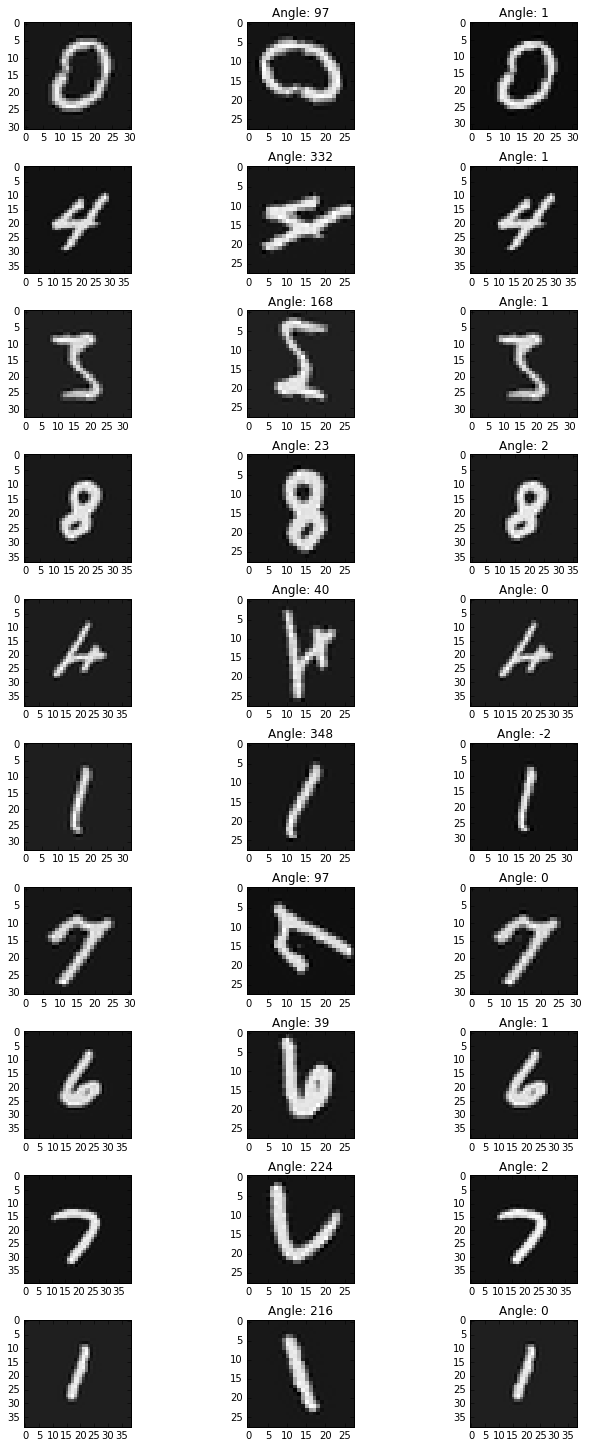

In [7]:
number = None
num_test_images = 10

plot_examples(X_test, y_test, y_test_angle, y_test_predicted_angle, num_test_images, number)

We can also show the angle error per class. Surprisingly, numbers such as 0 and 1, which are quite symmetric, don't have a significant higher error than other numbers.

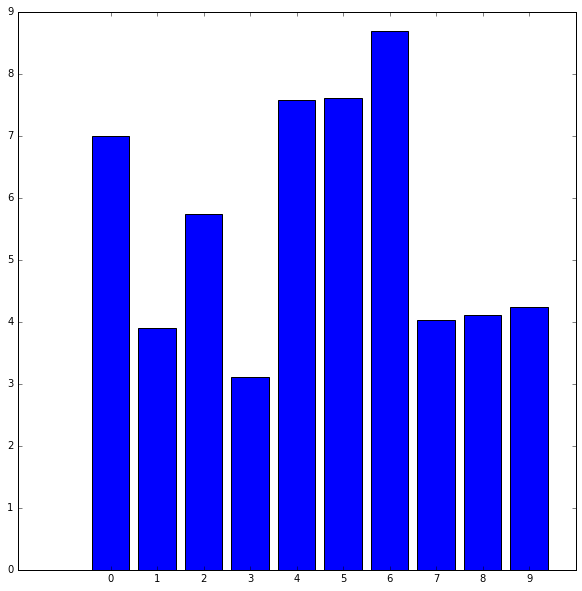

In [18]:
plot_error_hist(y_test, y_test_angle, y_test_predicted_angle)

Some examples of number 0.

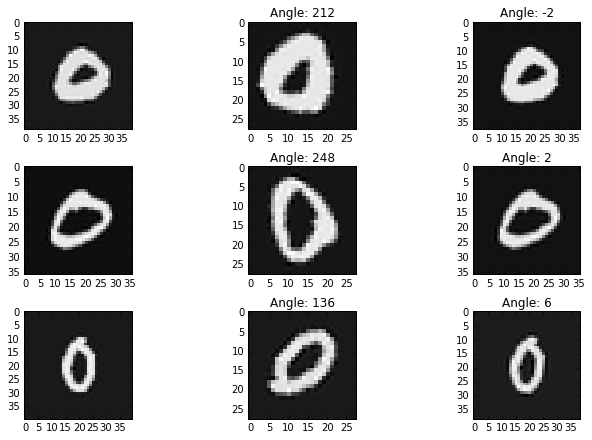

In [19]:
number = 0
num_test_images = 3

plot_examples(X_test, y_test, y_test_angle, y_test_predicted_angle, num_test_images, number)

Some examples of number 1 rotated 180 degrees.

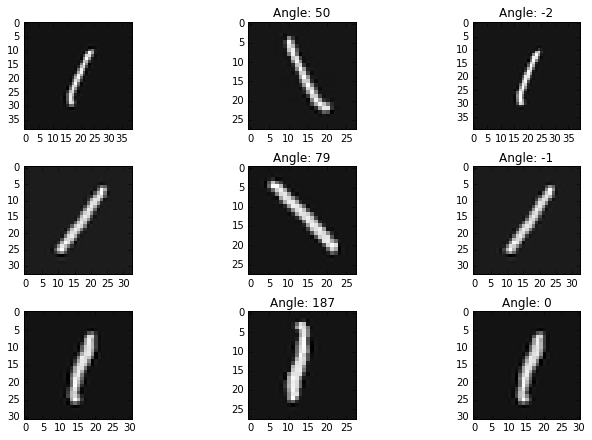

In [26]:
number = 1
num_test_images = 3

plot_examples(X_test, y_test, y_test_angle, y_test_predicted_angle, num_test_images, number)

---
## Regression task
As mentioned at the beginning, this task could have also been solved as a regression task. In that case, the last fully connected layer would have a single output neuron indicating the predicted angle. 

Keras does not provide a loss function suitable for this particular task. We could think that the MSE or MAE loss functions would be a good choice, but these would not calculate the error correctly when the difference between the true rotation angle and the predicted angle is more than 180. For example, the scalar difference between a rotation angle of 10 and a predicted angle of 30 would produce an error of 20, however, the scalar difference between a rotation angle of 10 and a predicted angle of 350 would produce an error of 340. It is easy to see how this is wrong, as the difference is also 20 but with negative sign.

We performed some experiments using only angles between 0 and 90 in order to compare the classification and regression loss functions, but the results were inconclusive (it seemed that the classification loss was still better, or at least it trained faster). 

A simple solution to this problem is to use a loss function that calculates the minimum difference between two angles rather than the scalar difference. Another improvement would possibly be to restrict the output values of the regressor to be between 0 and 360. These improvements remain to be studied as future work.